### Business Goal

##### Customer churn directly impacts recurring revenue and customer lifetime value. Acquiring new customers is significantly more expensive than retaining existing ones, making proactive churn prevention a critical business priority.
##### The goal of this project is to identify customers at high risk of churning and provide actionable insights that enable the business to intervene early with targeted retention strategies. By accurately predicting churn risk and understanding the key drivers behind customer attrition, the business can:
###### Prioritize retention efforts toward the most at-risk customers
###### Optimize retention spend by focusing on high-impact segments
###### Reduce revenue loss associated with unexpected customer churn
###### Improve long-term customer lifetime value and subscription stability
##### This project builds an end-to-end churn prediction pipeline that combines predictive modeling, explainability, and business-driven evaluation, enabling stakeholders to move from raw data to informed retention decisions.

In [1]:
# Import all Packages
import numpy as np
import pandas as pd
import random
import warnings

# Visualization (EDA only)
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn: data preparation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import precision_score, recall_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Scikit-learn: models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Scikit-learn: evaluation
from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    classification_report,
    confusion_matrix
)

# Settings
warnings.filterwarnings("ignore")
plt.style.use("seaborn-v0_8")


pd.set_option("display.float_format", "{:.3f}".format)

In [2]:
customer_data=pd.read_csv("Telco-Customer-Churn.csv")
customer_data 

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.850,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.950,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.850,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.300,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.700,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.800,1990.5,No
7039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.200,7362.9,No
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.600,346.45,No
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Mailed check,74.400,306.6,Yes


In [3]:
display(customer_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


None

### Obervations

##### The dataset contains 7,043 customer records with 21 columns. All columns have non-null values, indicating no missing data at the column level.

##### Most features are categorical like customer demographics, service subscriptions, and billing preferences. A small number of features are numerical, including tenure, monthly charges, and senior citizen status.

##### Since machine learning models require numerical inputs, the categorical features will need to be encoded before modeling. However, identifier columns like customerID will be excluded from the model as it provides no information.


In [4]:
# Drop identifier column and encode the target variable "Churn"
customer_data = customer_data.drop(columns=["customerID"])

customer_data["Churn"] = customer_data["Churn"].map({"Yes": 1, "No": 0})

### Data Type Correction: TotalCharges

Although `TotalCharges` represents a continuous monetary value, it is initially loaded as an object due to the presence of blank entries for a small number of customers (typically those with zero tenure). To ensure this feature is handled correctly during modeling, it was explicitly converted to a numeric type.

During this conversion, a small number of rows resulted in missing values, corresponding to customers without any billing history. These rows were removed, as they account for a negligible portion of the dataset and do not provide meaningful signal for churn prediction.



In [5]:
#Totalcharges should also be in float64 just like Monthlycharges
customer_data["TotalCharges"] = pd.to_numeric(
    customer_data["TotalCharges"],
    errors="coerce"
)

customer_data = customer_data.dropna(subset=["TotalCharges"])

customer_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7032 non-null   object 
 1   SeniorCitizen     7032 non-null   int64  
 2   Partner           7032 non-null   object 
 3   Dependents        7032 non-null   object 
 4   tenure            7032 non-null   int64  
 5   PhoneService      7032 non-null   object 
 6   MultipleLines     7032 non-null   object 
 7   InternetService   7032 non-null   object 
 8   OnlineSecurity    7032 non-null   object 
 9   OnlineBackup      7032 non-null   object 
 10  DeviceProtection  7032 non-null   object 
 11  TechSupport       7032 non-null   object 
 12  StreamingTV       7032 non-null   object 
 13  StreamingMovies   7032 non-null   object 
 14  Contract          7032 non-null   object 
 15  PaperlessBilling  7032 non-null   object 
 16  PaymentMethod     7032 non-null   object 
 17  

##### Numerical features also need to be standardized to keep feature magnitudes comparable, especially when combined with one-hot encoded variables. This helps prevent features with larger numeric ranges from influencing the model and improves overall training stability

In [6]:
# Training the data into train and test data 80/20 split
# Our target variable is "Churn" 

X = customer_data.drop(columns=["Churn"])
y = customer_data["Churn"]


#Creating 2 lists of the final numerical and categorical variables 
categorical_cols = X.select_dtypes(include=["object"]).columns.tolist()
numerical_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()

print("Categorical columns:", categorical_cols,"\n" )
print("Numerical columns:", numerical_cols,"\n")



X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

Categorical columns: ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod'] 

Numerical columns: ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges'] 



In [7]:
# Creating pipelines for Scaling and Encoding and making a combined Preprocessor pipeline

numeric_transformer = Pipeline(steps=[
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

# Combine preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numerical_cols),
        ("cat", categorical_transformer, categorical_cols)
    ]
)

In [8]:
# Create a logistic regression pipeline that applies preprocessing before model training
log_reg_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(max_iter=1000))
])


In [9]:
 # Fitting the training data in the model
log_reg_model.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['SeniorCitizen', 'tenure',
                                                   'MonthlyCharges',
                                                   'TotalCharges']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['gender', 'Partner',
                                                   'Dependents', 'PhoneService',
                                                   'MultipleLines',
                                                   'InternetService',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'DeviceProtection',
                                                   'TechSupport', 'StreamingTV',
                                                   'StreamingMovies',
                                                   'Contract',
                                                   'PaperlessBilling',
                                                   'PaymentMethod'])])),
                ('classifier', LogisticRegression(max_iter=1000))])

In [10]:
# Predict class labels
y_pred = log_reg_model.predict(X_test)

# Predict churn probabilities
y_proba = log_reg_model.predict_proba(X_test)[:, 1]


In [11]:
# Function to visualize the confusion matrix as a heatmap
def plot_confusion_matrix(y_true, y_pred, threshold=0.5):
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(6, 4))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=["Predicted No Churn", "Predicted Churn"],
        yticklabels=["Actual No Churn", "Actual Churn"]
    )

    title = "Confusion Matrix"
    if threshold:
        title += f" (Threshold = {threshold})"

    plt.title(title)
    plt.xlabel("Prediction")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

ROC-AUC: 0.8359290473207676
PR-AUC : 0.6228170767081351

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.89      0.87      1033
           1       0.65      0.57      0.61       374

    accuracy                           0.80      1407
   macro avg       0.75      0.73      0.74      1407
weighted avg       0.80      0.80      0.80      1407



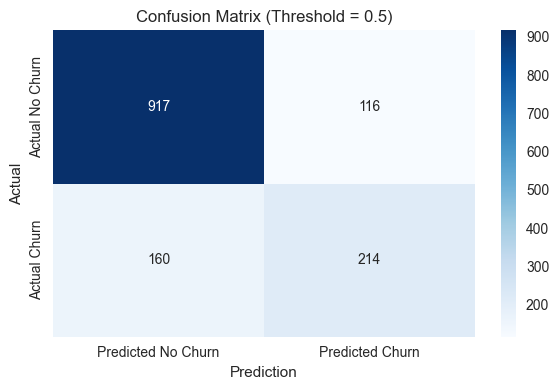

In [12]:
print("ROC-AUC:", roc_auc_score(y_test, y_proba))
print("PR-AUC :", average_precision_score(y_test, y_proba))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
plot_confusion_matrix(y_test, y_pred)


#### The default classification threshold of 0.5 may not be optimal for churn prediction. Therefore, multiple probability thresholds were explored to identify a better balance between precision and recall.


In [13]:
thresholds = np.arange(0.1, 0.9, 0.05)

for t in thresholds:
    y_pred_t = (y_proba >= t).astype(int)
    precision = precision_score(y_test, y_pred_t)
    recall = recall_score(y_test, y_pred_t)
    print(f"Threshold={t:.2f} | Precision={precision:.2f} | Recall={recall:.2f}")

Threshold=0.10 | Precision=0.40 | Recall=0.95
Threshold=0.15 | Precision=0.42 | Recall=0.91
Threshold=0.20 | Precision=0.46 | Recall=0.87
Threshold=0.25 | Precision=0.48 | Recall=0.82
Threshold=0.30 | Precision=0.51 | Recall=0.76
Threshold=0.35 | Precision=0.54 | Recall=0.72
Threshold=0.40 | Precision=0.58 | Recall=0.68
Threshold=0.45 | Precision=0.60 | Recall=0.63
Threshold=0.50 | Precision=0.65 | Recall=0.57
Threshold=0.55 | Precision=0.67 | Recall=0.49
Threshold=0.60 | Precision=0.68 | Recall=0.39
Threshold=0.65 | Precision=0.69 | Recall=0.29
Threshold=0.70 | Precision=0.76 | Recall=0.17
Threshold=0.75 | Precision=0.79 | Recall=0.07
Threshold=0.80 | Precision=0.88 | Recall=0.02
Threshold=0.85 | Precision=0.00 | Recall=0.00


Chosen threshold: 0.35

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.78      0.83      1033
           1       0.54      0.72      0.62       374

    accuracy                           0.77      1407
   macro avg       0.71      0.75      0.73      1407
weighted avg       0.79      0.77      0.77      1407



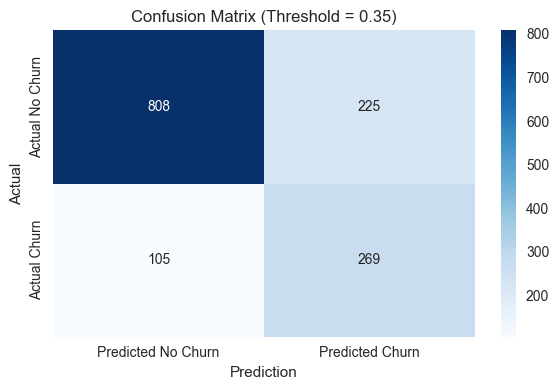

In [14]:
chosen_threshold = 0.35
y_pred_opt = (y_proba >= chosen_threshold).astype(int)

print("Chosen threshold:", chosen_threshold)
print("\nClassification Report:\n", classification_report(y_test, y_pred_opt))
plot_confusion_matrix(y_test, y_pred_opt,chosen_threshold)


### Threshold Selection

##### The model outputs churn probabilities rather than binary predictions. Instead of using the default 0.5 threshold, multiple probability thresholds were evaluated to understand the trade-off between precision and recall. A threshold of 0.35 was selected as it significantly improves churn recall while maintaining a reasonable precision, aligning with the business objective of proactively identifying at-risk customers for retention. This approach prioritizes recall over precision, reflecting the higher cost of missing a potential churner compared to contacting a small number of low-risk customers.


# Conclusion


### This project developed an end-to-end customer churn prediction pipeline using logistic regression with integrated preprocessing to ensure consistency and prevent data leakage. The model demonstrated strong ranking performance, achieving a ROC-AUC of approximately 0.836 and a PR-AUC of around 0.623, indicating effective identification of high-risk customers in an imbalanced churn setting.
### To better align predictions with business objectives, probability thresholds were evaluated instead of relying on the default 0.5 cutoff. A threshold of 0.35 was selected to improve churn recall while maintaining reasonable precision, prioritizing the proactive identification of at-risk customers for retention efforts.
### The final solution focuses on ranking churn risk and selecting an operating threshold that supports actionable retention decisions